In [318]:
import random
import gym
import math
import pandas as pd
import numpy as np
from gym import spaces
import matplotlib.pyplot as plt

#Criando a DQNetwork

##Nova Resolução do Problema por Deep Reinforcement Learning




In [319]:
# Distribuições de PRBs usadas no treinamento

mode = [[16,10,9],[10,11,14],[14,11,10],[11,16,9],[18,7,10],[13,14,8],[15,10,10],[16,8,11]]

In [320]:
class User():
  def __init__(self,user_id,service,pathloss,block_error_rate,bitrate,ul_snr):
    self.user_id = user_id                        #representa a identificação do usuário
    self.service = service                        #O tipo do serviço, fatia que o usuário será alocado
    self.bitrate = bitrate                        #O bitrate depende do tipo de serviço é representado em bps
    self.window = random.randint(5,10)            #Representa a quantidade de janelas de transmissão que o usuário ficará alocado
    self.window_original = random.randint(5,10)   #Representa a quantidade de janelas de transmissão que o usuário ficará alocado originalmente
    self.pathloss = pathloss                      #Define a perda de pacote
    self.block_error_rate = block_error_rate      #Define a taxa de erro nos blocos
    self.dl_snr = ul_snr                          #Define Signal-to-Noise
    self.alloc = 0                                #Indica se o usuário já foi alocado pelo menos uma vez
    self.requested_prbs = random.randint(4,7)
    self.requested_prbs_original = random.randint(4,7)
    self.wait  = 0                                   # Representa a quantidade de janelas que o usuário esperou até ser alocado

In [321]:
class Slice():
  def __init__(self,slice_id,slice_prbs,n_slice_users):
    self.slice_id = slice_id                                                  #Representa o id da fatia
    self.slice_prbs = slice_prbs                                              #Quantidade de PRBs da fatia variável
    self.slice_prbs_fixed = slice_prbs                                        #Quantidade de PRBs da fatia
    self.n_slice_users = n_slice_users                                        # Quantidade de usuários da fatia
    self.slice_users = []                                                     #Usuários da fatia, guarda tuplas que representam o usuário e quantas janelas ele está alocado na rede
    self.user_request = []                                                    #Lista de usuários que pediram para serem alocados na rede
    self.granted_prbs = math.floor(self.slice_prbs/self.n_slice_users)

  def update(self,slice_prbs):                                                #Função para atualizar atributos da fatia quando a divisão de PRBs for alterada
    self.slice_prbs = slice_prbs
    self.slice_prbs_fixed = slice_prbs

  def reset(self):
    self.slice_users = []
    self.user_request = []
    self.slice_prbs = self.slice_prbs_fixed

In [322]:
class RU():
  def __init__(self,ru_id,prbs,eMBB_users,URLLC_users,MTC_users, policy):
    self.ru_id = ru_id                                                          #Representa o ID da Radio-Unit
    self.prbs = prbs                                                            #Numero de PRBs
    self.n_eMBB_users = len(eMBB_users)                                            #Número de usuário do serviço
    self.n_URLLC_users = len(URLLC_users)                                          #Número de usuário do serviço
    self.n_MTC_users = len(MTC_users)                                              #Número de usuário do serviço
    self.n_users = self.n_eMBB_users + self.n_URLLC_users + self.n_MTC_users    #Numero total de usuários
    self.eMBB_users = eMBB_users                                                     #Usuários do serviço
    self.URLLC_users = URLLC_users                                                    #Usuários do serviço
    self.MTC_users = MTC_users                                                     #Usuários do serviço
    self.count =  0                                                            # Usa para contar os modos de treino
    self.policy = policy                                                       # Politica que esta sendo usada na RU

    #Criação das fatias da rede

    self.eMBB = Slice(0,15,self.n_eMBB_users)
    self.URLLC = Slice(1,10,self.n_URLLC_users)
    self.MTC = Slice(2,10,self.n_MTC_users)

  def reward(self,user,slice_id):                            #Função que define a recompensa da fatia
    if slice_id == 0:
        return user.bitrate - user.dl_snr - user.block_error_rate
    elif slice_id == 1:
        return -user.dl_snr - user.block_error_rate - user.pathloss
    elif slice_id == 2:
        return user.bitrate - user.dl_snr - user.pathloss
  def reset(self):
      self.eMBB.update(mode[self.count][0])
      self.URLLC.update(mode[self.count][1])
      self.MTC.update(mode[self.count][2])
      self.eMBB.reset()
      self.URLLC.reset()
      self.MTC.reset()
      for user in self.eMBB_users + self.URLLC_users + self.MTC_users:
          user.alloc = 0
          user.wait = 0  
          if self.policy=="RR":
            user.window = math.floor(user.requested_prbs_original* user.window_original/math.floor(15/5))
            user.requested_prbs = math.floor(15/5)
          if self.policy=="DQL":
            valor = 0                                 # Por enquanto é aleatorio, masw pode ser uma forma de melhorar o algoritmo
            user.window = math.floor(user.requested_prbs_original* user.window_original/(math.floor(12/5)+valor))
            user.requested_prbs = math.floor(12/5) + valor

      if self.count == 7:  # Esse numero é a posição do ultimo modo de treinamento
          self.count = 0
      else:
          self.count += 1

      

In [323]:
ue_URLLC = pd.read_csv('ue1.csv')
ue_eMBB = pd.read_csv('ue2.csv')
ue_MTC = pd.read_csv('ue3.csv')
atributos_para_manter = ['pl', 'ul_brate', 'ul_bler', 'dl_snr']

# Remove os atributos indesejados
ue_URLLC = ue_URLLC[atributos_para_manter]
ue1_URLLC = ue_URLLC.iloc[12]
ue2_URLLC = ue_URLLC.iloc[43]
ue3_URLLC = ue_URLLC.iloc[67]
ue4_URLLC = ue_URLLC.iloc[138]
ue5_URLLC = ue_URLLC.iloc[215]

ue_eMBB = ue_eMBB[atributos_para_manter]
ue1_eMBB = ue_eMBB.iloc[8]
ue2_eMBB = ue_eMBB.iloc[9]
ue3_eMBB = ue_eMBB.iloc[251]
ue4_eMBB = ue_eMBB.iloc[263]
ue5_eMBB = ue_eMBB.iloc[325]

ue_MTC = ue_MTC[atributos_para_manter]
ue1_MTC = ue_MTC.iloc[8]
ue2_MTC = ue_MTC.iloc[57]
ue3_MTC = ue_MTC.iloc[69]
ue4_MTC = ue_MTC.iloc[109]
ue5_MTC = ue_MTC.iloc[159]

In [324]:
# Criando os Usuários testes das fatias

ue1 = User(0,"URLLC",ue1_URLLC['pl'],ue1_URLLC['ul_bler'],ue1_URLLC['ul_brate'],ue1_URLLC['dl_snr'])
ue2 = User(1,"URLLC",ue2_URLLC['pl'],ue2_URLLC['ul_bler'],ue2_URLLC['ul_brate'],ue2_URLLC['dl_snr'])
ue3 = User(2,"URLLC",ue3_URLLC['pl'],ue3_URLLC['ul_bler'],ue3_URLLC['ul_brate'],ue3_URLLC['dl_snr'])
ue4 = User(3,"URLLC",ue4_URLLC['pl'],ue4_URLLC['ul_bler'],ue4_URLLC['ul_brate'],ue4_URLLC['dl_snr'])
ue5 = User(4,"URLLC",ue5_URLLC['pl'],ue5_URLLC['ul_bler'],ue5_URLLC['ul_brate'],ue5_URLLC['dl_snr'])

ue6 = User(0,"eMBB",ue1_eMBB['pl'],ue1_eMBB['ul_bler'],ue1_eMBB['ul_brate'],ue1_eMBB['dl_snr'])
ue7 = User(1,"eMBB",ue2_eMBB['pl'],ue2_eMBB['ul_bler'],ue2_eMBB['ul_brate'],ue2_eMBB['dl_snr'])
ue8 = User(2,"eMBB",ue3_eMBB['pl'],ue3_eMBB['ul_bler'],ue3_eMBB['ul_brate'],ue3_eMBB['dl_snr'])
ue9 = User(3,"eMBB",ue4_eMBB['pl'],ue4_eMBB['ul_bler'],ue4_eMBB['ul_brate'],ue4_eMBB['dl_snr'])
ue10 = User(4,"eMBB",ue5_eMBB['pl'],ue5_eMBB['ul_bler'],ue5_eMBB['ul_brate'],ue5_eMBB['dl_snr'])

ue11 = User(0,"MTC",ue1_MTC['pl'],ue1_MTC['ul_bler'],ue1_MTC['ul_brate'],ue1_MTC['dl_snr'])
ue12 = User(1,"MTC",ue2_MTC['pl'],ue2_MTC['ul_bler'],ue2_MTC['ul_brate'],ue2_MTC['dl_snr'])
ue13 = User(2,"MTC",ue3_MTC['pl'],ue3_MTC['ul_bler'],ue3_MTC['ul_brate'],ue3_MTC['dl_snr'])
ue14 = User(3,"MTC",ue4_MTC['pl'],ue4_MTC['ul_bler'],ue4_MTC['ul_brate'],ue4_MTC['dl_snr'])
ue15 = User(4,"MTC",ue5_MTC['pl'],ue5_MTC['ul_bler'],ue5_MTC['ul_brate'],ue5_MTC['dl_snr'])

list_URLLC = [ue1,ue2,ue3,ue4,ue5]
list_eMBB = [ue6,ue7,ue8,ue9,ue10]
list_MTC = [ue11,ue12,ue13,ue14,ue15]

RU_Test = RU(0,15,list_eMBB,list_URLLC,list_MTC,"DQL")

In [325]:
class UserSelectionEnvironment(gym.Env):
    def __init__(self,RU):
        super(UserSelectionEnvironment, self).__init__()
        self.RU = RU                                                                    # Recebe uma Radio Unit para treinar
        self.observation_space = spaces.Discrete(self.RU.n_users)                       # Espaço de observação com todos os usuários
        self.available_actions_eMBB = self.RU.eMBB.user_request                         # Ações iniciais
        self.available_actions_URLLC = self.RU.URLLC.user_request                       # Ações iniciais
        self.available_actions_MTC = self.RU.MTC.user_request                           # Ações iniciais
        self.action_space = spaces.Discrete(self.RU.n_users)                            # Espaço de ação com ações de seleção de usuário
        self.culmulative_reward_eMBB = 0
        self.culmulative_reward_URLLC = 0
        self.culmulative_reward_MTC = 0
        self.state = None
        self.done = False

    def reset(self):
        self.RU.reset()     
        self.culmulative_reward_eMBB = 0
        self.culmulative_reward_URLLC = 0
        self.culmulative_reward_MTC = 0                                                 
        self.state = None
        self.done = False

    def step(self, action):

      reward = [0,0,0]
      # Remove da fatia os usuários que já terminaram
      # E devolve a fatia os PRBs que eram utulizados

      # Crie cópias das listas para evitar problemas de modificação durante a iteração
      eMBB_users_copy = self.RU.eMBB.slice_users.copy()
      URLLC_users_copy = self.RU.URLLC.slice_users.copy()
      MTC_users_copy = self.RU.MTC.slice_users.copy()

      # Iteração e remoção na cópia da lista
      for [user, window] in eMBB_users_copy:
          if user.window == window:
              self.RU.eMBB.slice_users.remove([user, window])
              self.RU.eMBB.slice_prbs += user.requested_prbs

      for [user, window] in URLLC_users_copy:
          if user.window == window:
              self.RU.URLLC.slice_users.remove([user, window])
              self.RU.URLLC.slice_prbs += user.requested_prbs

      for [user, window] in MTC_users_copy:
          if user.window == window:
              self.RU.MTC.slice_users.remove([user, window])
              self.RU.MTC.slice_prbs += user.requested_prbs


      # Ação é um vetor com 3 usuários, um para cada fatia

      if action[0] !="None":
        if action[0].requested_prbs<= self.RU.eMBB.slice_prbs: # Só adiciona o usuário se há recursos disponiveis para ele
          for user in self.RU.eMBB_users:
              #print(user.user_id,user.alloc)
              if user.user_id == action[0].user_id:
                user.alloc = 1
                action[0].alloc = 1
                self.RU.eMBB.user_request.remove(user)          # Remove dos os usuários que estão solicitando alocação
                self.RU.eMBB.slice_users.append([user,0])       # Adiciona nos usuários alocados
                self.RU.eMBB.slice_prbs += -user.requested_prbs
          self.culmulative_reward_eMBB += self.RU.reward(action[0],0)   #Calcula a recompensa da ação do usuário
          reward[0] = self.RU.reward(action[0],0)

      if action[1] !="None":
        if action[1].requested_prbs<= self.RU.URLLC.slice_prbs:# Só adiciona o usuário se há recursos disponiveis para ele
          for user in self.RU.URLLC_users:
              #print(user.user_id,user.alloc)
              if user.user_id == action[1].user_id:
                user.alloc = 1
                action[1].alloc = 1
                self.RU.URLLC.user_request.remove(user)         #Remove dos os usuários que estão solicitando alocação
                self.RU.URLLC.slice_users.append([user,0])      #Adiciona nos usuários alocados
                self.RU.URLLC.slice_prbs += -user.requested_prbs
          self.culmulative_reward_URLLC += self.RU.reward(action[1],1)   #Calcula a recompensa da ação do usuário
          reward[1] = self.RU.reward(action[1],1)

      if action[2] !="None":
        if action[2].requested_prbs<= self.RU.MTC.slice_prbs: # Só adiciona o usuário se há recursos disponiveis para ele
          for user in self.RU.MTC_users:
              #print(user.user_id,user.alloc)
              if user.user_id == action[2].user_id:
                user.alloc = 1
                action[2].alloc = 1
                self.RU.MTC.user_request.remove(user)          #Remove dos os usuários que estão solicitando alocação
                self.RU.MTC.slice_users.append([user,0])       #Adiciona nos usuários alocados
                self.RU.MTC.slice_prbs += -user.requested_prbs
          self.culmulative_reward_MTC += self.RU.reward(action[2],2)   #Calcula a recompensa da ação do usuário
          reward[2] = self.RU.reward(action[2],2)

      # Falta atualizar parametros da rede, como as janelas etc
      for user in self.RU.eMBB.slice_users:
        user[1]+=1
      for user in self.RU.URLLC.slice_users:
        user[1]+=1
      for user in self.RU.MTC.slice_users:
        user[1]+=1

      waiters_eMBB =[]
      waiters_URLLC = []
      waiters_MTC = []

      # e antes de colocar mais usuários adiciona +1 no tempo de espera de todos os usuários
      for user in self.RU.eMBB.user_request:
        if user not in waiters_eMBB:
          user.wait += 1
          waiters_eMBB.append(user)

      for user in self.RU.URLLC.user_request:
        if user not in waiters_URLLC:
          user.wait += 1
          waiters_URLLC.append(user)

      for user in self.RU.MTC.user_request:
        if user not in waiters_MTC:
          user.wait += 1
          waiters_MTC.append(user)

      
      # Coloca novos usuários na lista para serem alocados
      possible_alocations0 = [user for user in self.RU.eMBB_users if user.alloc!=1]
      elements = random.randint(0, len(possible_alocations0))
      selected_users = random.sample(possible_alocations0, elements)
      self.RU.eMBB.user_request.extend(selected_users)

      possible_alocations1 = [user for user in self.RU.URLLC_users if user.alloc!=1]
      elements = random.randint(0, len(possible_alocations1))
      selected_users = random.sample(possible_alocations1, elements)
      self.RU.URLLC.user_request.extend(selected_users)

      possible_alocations2 = [user for user in self.RU.MTC_users if user.alloc!=1]
      elements = random.randint(0, len(possible_alocations2))
      selected_users = random.sample(possible_alocations2, elements)
      self.RU.MTC.user_request.extend(selected_users)

      # Atualize o estado para o usuário selecionado
      self.state = [self.RU.eMBB.slice_users,self.RU.URLLC.slice_users,self.RU.MTC.slice_users]

      self.available_actions_eMBB = self.RU.eMBB.user_request[:]
      self.available_actions_URLLC = self.RU.URLLC.user_request[:]
      self.available_actions_MTC = self.RU.MTC.user_request[:]

      done_eMBB = all(user.alloc != 0 for user in self.RU.eMBB_users)
      done_URLLC = all(user.alloc != 0 for user in self.RU.URLLC_users)
      done_MTC = all(user.alloc != 0 for user in self.RU.MTC_users)

      done = done_eMBB and done_URLLC and done_MTC

      observation = [self.culmulative_reward_eMBB,self.culmulative_reward_URLLC,self.culmulative_reward_MTC]
      return self.state, observation,reward, done



# Crie o ambiente
env = UserSelectionEnvironment(RU_Test)


In [326]:
# Tabelas de Valores
q_table_eMBB = np.random.uniform(low=-0.5, high=0.5, size=(env.RU.n_eMBB_users, env.RU.n_eMBB_users))
q_table_URLLC = np.random.uniform(low=-0.5, high=0.5, size=(env.RU.n_URLLC_users, env.RU.n_URLLC_users))
q_table_MTC = np.random.uniform(low=-0.5, high=0.5, size=(env.RU.n_MTC_users, env.RU.n_MTC_users))

In [327]:
wait_values_DQN_eMBB = [[] for i in range(RU_Test.n_eMBB_users)]
wait_values_DQN_URLLC = [[] for i in range(RU_Test.n_URLLC_users)]
wait_values_DQN_MTC = [[] for i in range(RU_Test.n_MTC_users)]

In [328]:
culmulative_observation_eMBB = []
culmulative_observation_URLLC = []
culmulative_observation_MTC = []
DQL_iteration = []
LEARNING_RATE = 0.1
DISCOUNT = 0.95
EPISODES = 4096
# Exploration settings
epsilon = 1  # not a constant, going to be decayed
START_EPSILON_DECAYING = 1
END_EPSILON_DECAYING = EPISODES//2
epsilon_decay_value = epsilon/(END_EPSILON_DECAYING - START_EPSILON_DECAYING)

for episode in range(EPISODES):
    done = False
    env.reset()
    iteracoes = 0
    while done == False:
        iteracoes +=1
        action = []
        # Get action from Q table
        if len(env.RU.eMBB.user_request)!=0:
            index_users = [user.user_id for user in env.RU.eMBB.user_request]
            # Extraindo os valores correspondentes na tabela Q para os usuários específicos
            valores_usuarios_especificos = q_table_eMBB[index_users]
            # Encontrando o índice do usuário com o maior valor
            indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
            # Obtendo o usuário com o maior valor
            action.append(env.RU.eMBB_users[index_users[int(indice_usuario_max_valor/5)]])
            current_q_eMBB = valores_usuarios_especificos[int(indice_usuario_max_valor/5)]
        else: action.append("None")

        if len(env.RU.URLLC.user_request)!=0:
            index_users = [user.user_id for user in env.RU.URLLC.user_request]
            # Extraindo os valores correspondentes na tabela Q para os usuários específicos
            valores_usuarios_especificos = q_table_URLLC[index_users]
            # Encontrando o índice do usuário com o maior valor
            indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
            # Obtendo o usuário com o maior valor
            action.append(env.RU.URLLC_users[index_users[int(indice_usuario_max_valor/5)]])
            current_q_URLLC = valores_usuarios_especificos[int(indice_usuario_max_valor/5)]
        else: action.append("None")

        if len(env.RU.MTC.user_request)!=0:
            index_users = [user.user_id for user in env.RU.MTC.user_request]
            # Extraindo os valores correspondentes na tabela Q para os usuários específicos
            valores_usuarios_especificos = q_table_MTC[index_users]
            # Encontrando o índice do usuário com o maior valor
            indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
            # Obtendo o usuário com o maior valor
            action.append(env.RU.MTC_users[index_users[int(indice_usuario_max_valor/5)]])
            current_q_MTC = valores_usuarios_especificos[int(indice_usuario_max_valor/5)]
        else: action.append("None")

        new_state,observation, reward, done = env.step(action)
        culmulative_observation_eMBB.append(observation[0])
        culmulative_observation_URLLC.append(observation[1])
        culmulative_observation_MTC.append(observation[2])
        # If simulation did not end yet after last step - update Q table
        if done == False:

            if action[0] !="None" and env.RU.eMBB.user_request!=[]:
                # Maximum possible Q value in next step (for new state)
                index_users_eMBB = [user.user_id for user in env.RU.eMBB.user_request]
                # Extraindo os valores correspondentes na tabela Q para os usuários específicos
                valores_usuarios_especificos = q_table_eMBB[index_users_eMBB]
                # Encontrando o índice do usuário com o maior valor
                indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
                # Obtendo o valor do melhor usuário para proxima ação
                max_future_q_eMBB = np.max(valores_usuarios_especificos[int(indice_usuario_max_valor/5)])
                # And here's our equation for a new Q value for current state and action
                new_q_eMBB = (1 - LEARNING_RATE) * current_q_eMBB + LEARNING_RATE * (reward[0] + DISCOUNT * max_future_q_eMBB)
                # Update Q tables with new Q values
                q_table_eMBB[index_users_eMBB] = new_q_eMBB


            if action[1] !="None" and env.RU.URLLC.user_request!=[]:
                index_users_URLLC = [user.user_id for user in env.RU.URLLC.user_request]
                # Extraindo os valores correspondentes na tabela Q para os usuários específicos
                valores_usuarios_especificos = q_table_URLLC[index_users_URLLC]
                # Encontrando o índice do usuário com o maior valor
                indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
                # Obtendo o valor do melhor usuário para proxima ação
                max_future_q_URLLC = np.max(valores_usuarios_especificos[int(indice_usuario_max_valor/5)])
                # And here's our equation for a new Q value for current state and action
                new_q_URLLC = (1 - LEARNING_RATE) * current_q_URLLC + LEARNING_RATE * (reward[1] + DISCOUNT * max_future_q_URLLC)
                # Update Q tables with new Q values
                q_table_URLLC[index_users_URLLC] = new_q_URLLC
            

            if action[2] !="None" and env.RU.MTC.user_request!=[]:
                index_users_MTC = [user.user_id for user in env.RU.MTC.user_request]
                # Extraindo os valores correspondentes na tabela Q para os usuários específicos
                valores_usuarios_especificos = q_table_MTC[index_users_MTC]
                # Encontrando o índice do usuário com o maior valor
                indice_usuario_max_valor = np.argmax(valores_usuarios_especificos)
                # Obtendo o valor do melhor usuário para proxima ação
                max_future_q_MTC = np.max(valores_usuarios_especificos[int(indice_usuario_max_valor/5)])
                # And here's our equation for a new Q value for current state and action
                new_q_MTC = (1 - LEARNING_RATE) * current_q_MTC + LEARNING_RATE * (reward[2] + DISCOUNT * max_future_q_MTC)
                # Update Q tables with new Q values
                q_table_MTC[index_users_MTC] = new_q_MTC
    DQL_iteration.append(iteracoes)
    for user in RU_Test.eMBB_users:
        wait_values_DQN_eMBB[user.user_id].append(user.wait)
    for user in RU_Test.URLLC_users:
        wait_values_DQN_URLLC[user.user_id].append(user.wait)
    for user in RU_Test.MTC_users:
        wait_values_DQN_MTC[user.user_id].append(user.wait)
# Decaying is being done every episode if episode number is within decaying range
if END_EPSILON_DECAYING >= episode >= START_EPSILON_DECAYING:
    epsilon -= epsilon_decay_value



<h3> Resolução por Round Robin</h3>

In [329]:
wait_values_RR_eMBB = [[] for i in range(RU_Test.n_eMBB_users)]
wait_values_RR_URLLC = [[] for i in range(RU_Test.n_URLLC_users)]
wait_values_RR_MTC = [[] for i in range(RU_Test.n_MTC_users)]

In [330]:
RR_culmulative_observation_eMBB = []
RR_culmulative_observation_URLLC = []
RR_culmulative_observation_MTC = []
RR_iteration = []

env.RU.policy ="RR"

for episode in range(EPISODES):
    done = False
    env.reset()
    iteracoes = 0
    while done == False:
        iteracoes += 1
        action = []
        # Get action
        if len(env.RU.eMBB.user_request)!=0:
            # Coloca o primeiro usuário que está na lista
            index_users = [user.user_id for user in env.RU.eMBB.user_request]
            action.append(env.RU.eMBB_users[index_users[0]])
        else: action.append("None")

        if len(env.RU.URLLC.user_request)!=0:
            # Coloca o primeiro usuário que está na lista
            index_users = [user.user_id for user in env.RU.URLLC.user_request]
            action.append(env.RU.URLLC_users[index_users[0]])
        else: action.append("None")

        if len(env.RU.MTC.user_request)!=0:
            # Coloca o primeiro usuário que está na lista
            index_users = [user.user_id for user in env.RU.MTC.user_request]
            action.append(env.RU.MTC_users[index_users[0]])
        else: action.append("None")

        new_state,observation, reward, done = env.step(action)
        RR_culmulative_observation_eMBB.append(observation[0])
        RR_culmulative_observation_URLLC.append(observation[1])
        RR_culmulative_observation_MTC.append(observation[2])
    RR_iteration.append(iteracoes)
    for user in RU_Test.eMBB_users:
        wait_values_RR_eMBB[user.user_id].append(user.wait)
    for user in RU_Test.URLLC_users:
        wait_values_RR_URLLC[user.user_id].append(user.wait)
    for user in RU_Test.MTC_users:
        wait_values_RR_MTC[user.user_id].append(user.wait)
env.close()

c:\Users\Caio\anaconda3\Lib\site-packages\IPython\core\events.py:93: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  func(*args, **kwargs)
c:\Users\Caio\anaconda3\Lib\site-packages\IPython\core\pylabtools.py:152: UserWarning: Creating legend with loc="best" can be slow with large amounts of data.
  fig.canvas.print_figure(bytes_io, **kw)


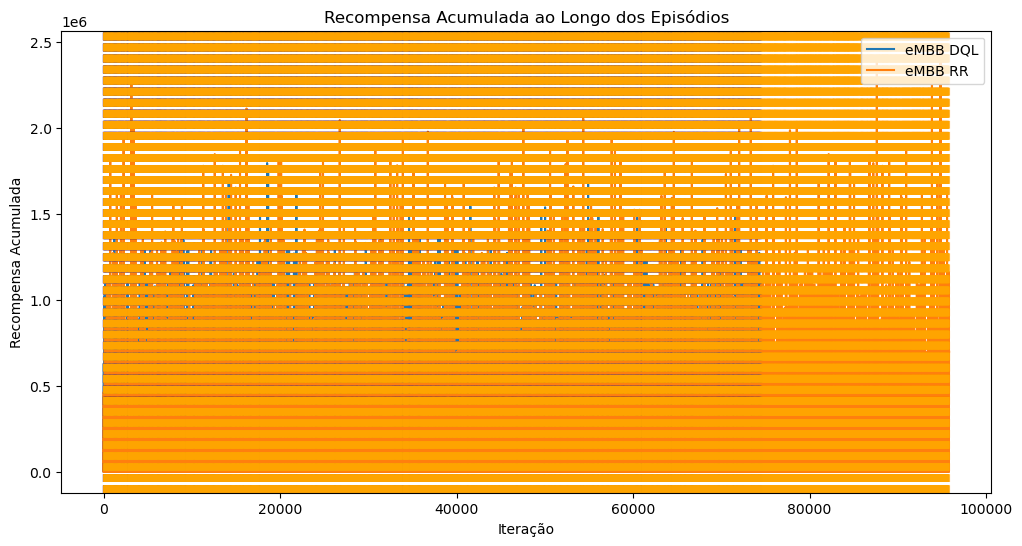

In [331]:
# Encontre os índices onde a recompensa é 0
zeros_indices_eMBB = [i for i, x in enumerate(culmulative_observation_eMBB) if x == 0]
zeros_indices_RR_eMBB = [i for i, x in enumerate(RR_culmulative_observation_eMBB) if x == 0]

# Encontre os 0s que estão pelo menos a 10 posições de distância um do outro
filtered_zeros_indices_eMBB = [zeros_indices_eMBB[0]] + [zeros_indices_eMBB[i] for i in range(1, len(zeros_indices_eMBB)) if zeros_indices_eMBB[i] - zeros_indices_eMBB[i-1] >= 10]
filtered_zeros_indices_RR_eMBB = [zeros_indices_RR_eMBB[0]] + [zeros_indices_RR_eMBB[i] for i in range(1, len(zeros_indices_RR_eMBB)) if zeros_indices_RR_eMBB[i] - zeros_indices_RR_eMBB[i-1] >= 10]

# Aumente o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plote os dois gráficos juntos
plt.plot(culmulative_observation_eMBB, label='eMBB DQL')
plt.plot(RR_culmulative_observation_eMBB, label='eMBB RR')

# Adicione linhas verticais onde a recompensa zera
for idx in filtered_zeros_indices_eMBB:
    plt.axvline(x=idx, color='blue', linestyle='--', alpha=0.5)

for idx in filtered_zeros_indices_RR_eMBB:
    plt.axvline(x=idx, color='orange', linestyle='--', alpha=0.5)

# Adicione rótulos e título
plt.xlabel('Iteração')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada ao Longo dos Episódios')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
#plt.show()

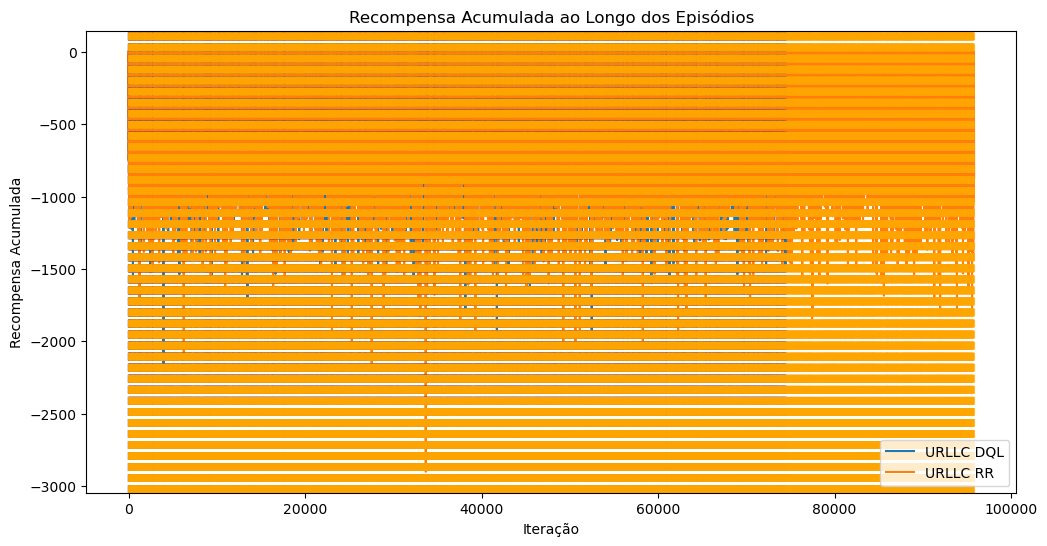

In [332]:
# Encontre os índices onde a recompensa é 0
zeros_indices_URLLC = [i for i, x in enumerate(culmulative_observation_URLLC) if x == 0]
zeros_indices_RR_URLLC = [i for i, x in enumerate(RR_culmulative_observation_URLLC) if x == 0]

# Encontre os 0s que estão pelo menos a 10 posições de distância um do outro
filtered_zeros_indices_URLLC = [zeros_indices_URLLC[0]] + [zeros_indices_URLLC[i] for i in range(1, len(zeros_indices_URLLC)) if zeros_indices_URLLC[i] - zeros_indices_URLLC[i-1] >= 10]
filtered_zeros_indices_RR_URLLC = [zeros_indices_RR_URLLC[0]] + [zeros_indices_RR_URLLC[i] for i in range(1, len(zeros_indices_RR_URLLC)) if zeros_indices_RR_URLLC[i] - zeros_indices_RR_URLLC[i-1] >= 10]

# Aumente o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plote os dois gráficos juntos
plt.plot(culmulative_observation_URLLC, label='URLLC DQL')
plt.plot(RR_culmulative_observation_URLLC, label='URLLC RR')

# Adicione linhas verticais onde a recompensa zera
for idx in filtered_zeros_indices_URLLC:
    plt.axvline(x=idx, color='blue', linestyle='--', alpha=0.5)

for idx in filtered_zeros_indices_RR_URLLC:
    plt.axvline(x=idx, color='orange', linestyle='--', alpha=0.5)

# Adicione rótulos e título
plt.xlabel('Iteração')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada ao Longo dos Episódios')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
#plt.show()

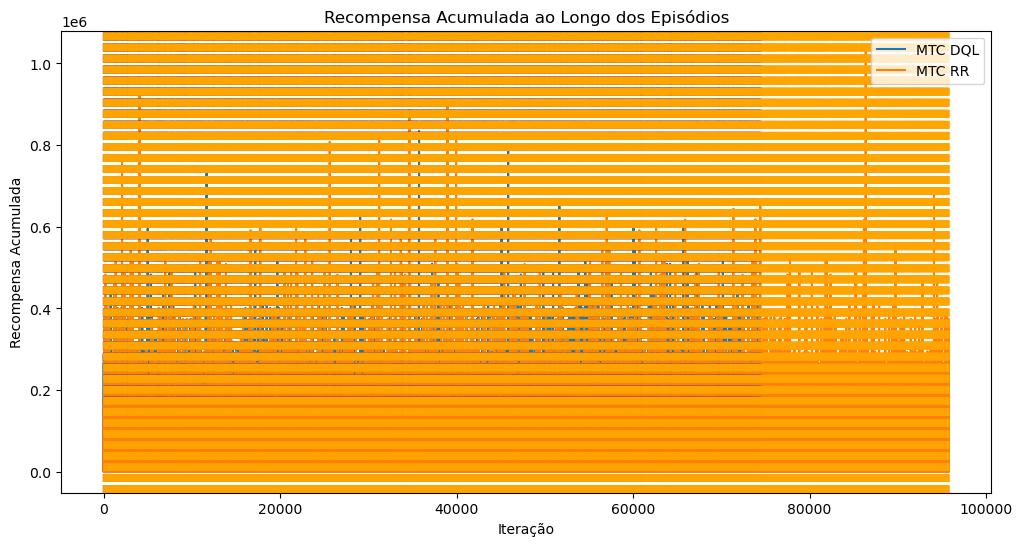

In [333]:
# Encontre os índices onde a recompensa é 0
zeros_indices_MTC = [i for i, x in enumerate(culmulative_observation_MTC) if x == 0]
zeros_indices_RR_MTC = [i for i, x in enumerate(RR_culmulative_observation_MTC) if x == 0]

# Encontre os 0s que estão pelo menos a 10 posições de distância um do outro
filtered_zeros_indices_MTC = [zeros_indices_MTC[0]] + [zeros_indices_MTC[i] for i in range(1, len(zeros_indices_MTC)) if zeros_indices_MTC[i] - zeros_indices_MTC[i-1] >= 10]
filtered_zeros_indices_RR_MTC = [zeros_indices_RR_MTC[0]] + [zeros_indices_RR_MTC[i] for i in range(1, len(zeros_indices_RR_MTC)) if zeros_indices_RR_MTC[i] - zeros_indices_RR_MTC[i-1] >= 10]

# Aumente o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plote os dois gráficos juntos
plt.plot(culmulative_observation_MTC, label='MTC DQL')
plt.plot(RR_culmulative_observation_MTC, label='MTC RR')

# Adicione linhas verticais onde a recompensa zera
for idx in filtered_zeros_indices_MTC:
    plt.axvline(x=idx, color='blue', linestyle='--', alpha=0.5)

for idx in filtered_zeros_indices_RR_MTC:
    plt.axvline(x=idx, color='orange', linestyle='--', alpha=0.5)

# Adicione rótulos e título
plt.xlabel('Iteração')
plt.ylabel('Recompensa Acumulada')
plt.title('Recompensa Acumulada ao Longo dos Episódios')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
#plt.show()

Média DQN: 18.1943359375
Média RR: 23.39501953125


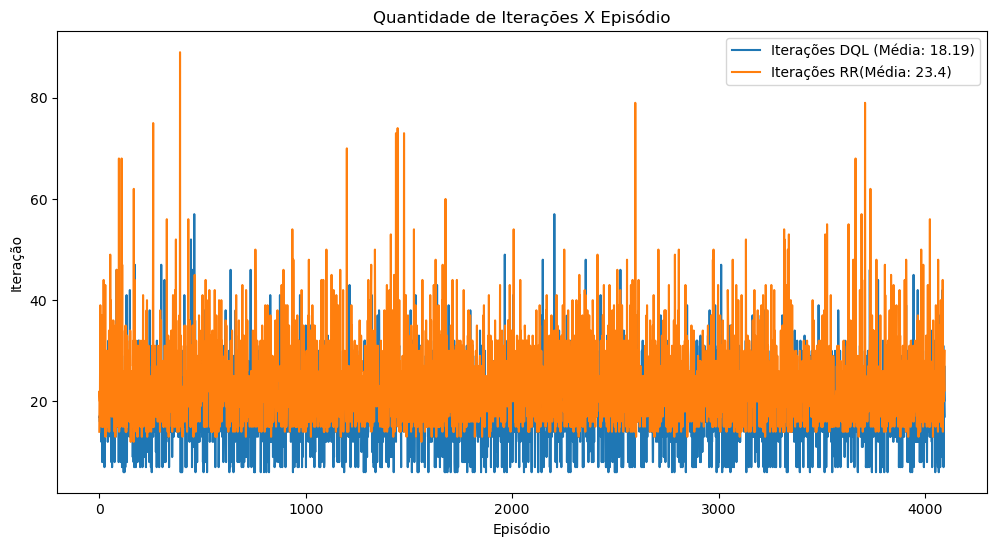

In [363]:
# Aumente o tamanho do gráfico
plt.figure(figsize=(12, 6))

# Plote os dois gráficos juntos
plt.plot(DQL_iteration, label='Iterações DQL (Média: ' + str(np.mean(DQL_iteration).round(2)) + ')')

plt.plot(RR_iteration, label='Iterações RR(Média: ' + str(np.mean(RR_iteration).round(2)) + ')')


# Adicione rótulos e título
plt.xlabel('Episódio')
plt.ylabel('Iteração')
plt.title('Quantidade de Iterações X Episódio')

# Adicione uma legenda
plt.legend()

# Exiba o gráfico
#plt.show()
print("Média DQN:",np.mean(DQL_iteration))
print("Média RR:",np.mean(RR_iteration))


<h3>Histogramas de Latência de Fila</h3>

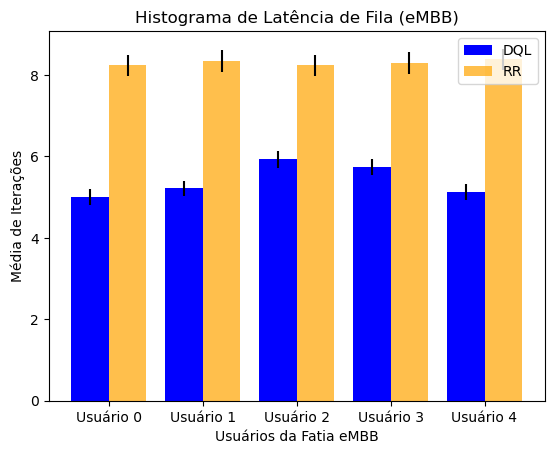

In [335]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_eMBB = [np.mean(lista) for lista in wait_values_DQN_eMBB]
means_RR_eMBB = [np.mean(lista) for lista in wait_values_RR_eMBB]
std_DQN_eMBB = [np.std(lista, ddof=1) for lista in wait_values_DQN_eMBB]
std_RR_eMBB = [np.std(lista, ddof=1) for lista in wait_values_RR_eMBB]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_eMBB))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_eMBB]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_eMBB]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_eMBB, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_eMBB, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia eMBB')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência de Fila (eMBB)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_eMBB))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


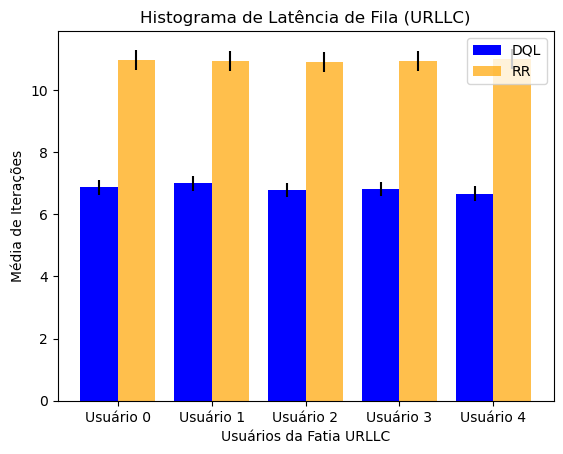

In [336]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_URLLC = [np.mean(lista) for lista in wait_values_DQN_URLLC]
means_RR_URLLC = [np.mean(lista) for lista in wait_values_RR_URLLC]
std_DQN_URLLC = [np.std(lista, ddof=1) for lista in wait_values_DQN_URLLC]
std_RR_URLLC = [np.std(lista, ddof=1) for lista in wait_values_RR_URLLC]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_URLLC))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_URLLC]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_URLLC]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_URLLC, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_URLLC, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia URLLC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência de Fila (URLLC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_URLLC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


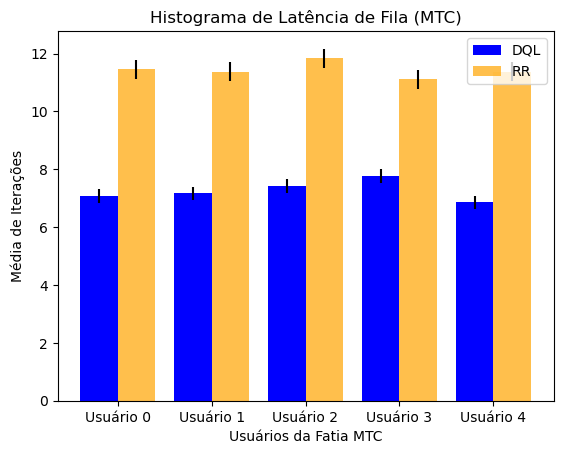

In [337]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_MTC = [np.mean(lista) for lista in wait_values_DQN_MTC]
means_RR_MTC = [np.mean(lista) for lista in wait_values_RR_MTC]
std_DQN_MTC = [np.std(lista, ddof=1) for lista in wait_values_DQN_MTC]
std_RR_MTC = [np.std(lista, ddof=1) for lista in wait_values_RR_MTC]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_MTC))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_MTC]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_MTC]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_MTC, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_MTC, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia MTC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência de Fila (MTC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_MTC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


<h3>Histogramas de Latência</h3>

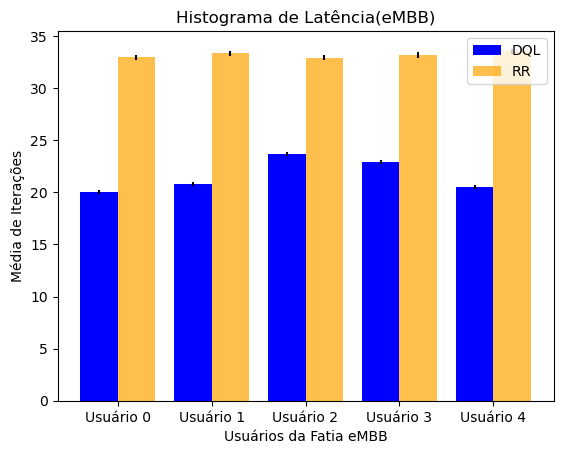

In [344]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_eMBB = [np.mean(lista)+espera for lista,espera in zip(wait_values_DQN_eMBB,means_DQN_eMBB)]
means_RR_eMBB = [np.mean(lista)+espera for lista,espera in zip(wait_values_RR_eMBB,means_RR_eMBB)]
std_DQN_eMBB = [np.std(lista, ddof=1) for lista in wait_values_DQN_eMBB]
std_RR_eMBB = [np.std(lista, ddof=1) for lista in wait_values_RR_eMBB]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_eMBB))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_eMBB]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_eMBB]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_eMBB, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_eMBB, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia eMBB')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência(eMBB)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_eMBB))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


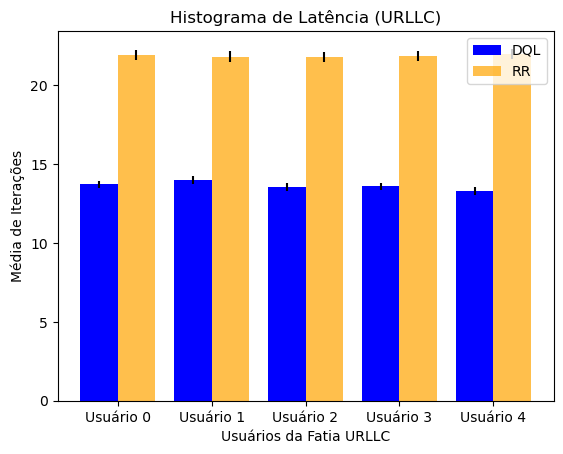

In [345]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_URLLC = [np.mean(lista)+espera for lista,espera in zip(wait_values_DQN_URLLC,means_DQN_URLLC)]
means_RR_URLLC = [np.mean(lista)+espera for lista,espera in zip(wait_values_RR_URLLC,means_RR_URLLC)]
std_DQN_URLLC = [np.std(lista, ddof=1) for lista in wait_values_DQN_URLLC]
std_RR_URLLC = [np.std(lista, ddof=1) for lista in wait_values_RR_URLLC]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_URLLC))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_URLLC]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_URLLC]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_URLLC, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_URLLC, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia URLLC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência (URLLC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_URLLC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


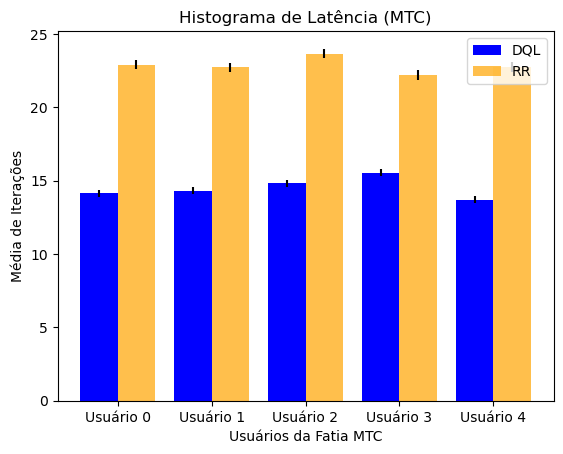

In [346]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_MTC = [np.mean(lista)+espera for lista,espera in zip(wait_values_DQN_MTC,means_DQN_MTC)]
means_RR_MTC = [np.mean(lista)+espera for lista,espera in zip(wait_values_RR_MTC,means_RR_MTC)]
std_DQN_MTC = [np.std(lista, ddof=1) for lista in wait_values_DQN_MTC]
std_RR_MTC = [np.std(lista, ddof=1) for lista in wait_values_RR_MTC]

# Criar um array de posições
posicoes = np.arange(len(means_DQN_MTC))

# Configurar o nível de confiança desejado (95%)
conf_level = 0.95

# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_DQN_MTC]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(lista)-1, loc=np.mean(lista), scale=stats.sem(lista)) for lista in wait_values_RR_MTC]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, means_DQN_MTC, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, means_RR_MTC, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia MTC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Latência (MTC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_MTC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
#plt.show()


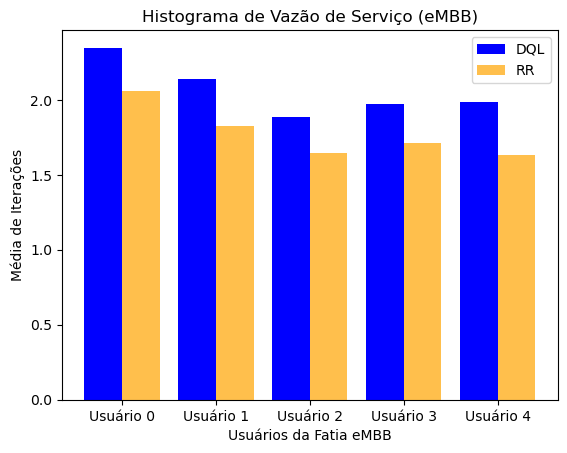

In [364]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_eMBB = [np.mean(lista) for lista in wait_values_DQN_eMBB]
means_RR_eMBB = [np.mean(lista) for lista in wait_values_RR_eMBB]

# Calculo da Vazão
vazao_DQN = [user.window* user.requested_prbs / (espera + user.window)  for user, espera in zip(list_eMBB, means_DQN_eMBB)]
vazao_RR = [user.window* user.requested_prbs / (espera + user.window) for user, espera in zip(list_eMBB, means_RR_eMBB)]

# Calcular o desvio padrão da vazão para DQN e RR
std_DQN_eMBB = np.std(vazao_DQN, ddof=1)  # Adicionando ddof=1 para calcular o desvio padrão amostral
std_RR_eMBB = np.std(vazao_RR, ddof=1)

# Criar um array de posições
posicoes = np.arange(len(means_DQN_eMBB))

conf_level = 0.0
# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(wait_values_DQN_eMBB[i])-1, loc=means_DQN_eMBB[i], scale=stats.sem(wait_values_DQN_eMBB[i])) for i in range(len(means_DQN_eMBB))]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(wait_values_RR_eMBB[i])-1, loc=means_RR_eMBB[i], scale=stats.sem(wait_values_RR_eMBB[i])) for i in range(len(means_RR_eMBB))]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, vazao_DQN, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, vazao_RR, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia eMBB')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Vazão de Serviço (eMBB)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_eMBB))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

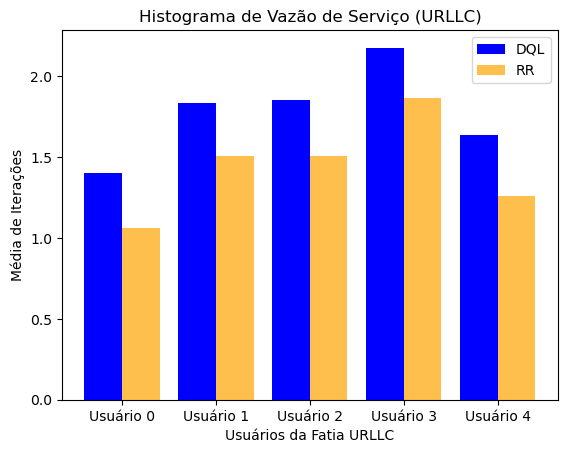

In [365]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_URLLC = [np.mean(lista) for lista in wait_values_DQN_URLLC]
means_RR_URLLC = [np.mean(lista) for lista in wait_values_RR_URLLC]

# Calculo da Vazão
vazao_DQN = [user.window* user.requested_prbs / (espera + user.window) for user, espera in zip(list_URLLC, means_DQN_URLLC)]
vazao_RR = [user.window* user.requested_prbs / (espera + user.window) for user, espera in zip(list_URLLC, means_RR_URLLC)]

# Calcular o desvio padrão da vazão para DQN e RR
std_DQN_URLLC = np.std(vazao_DQN, ddof=1)  # Adicionando ddof=1 para calcular o desvio padrão amostral
std_RR_URLLC = np.std(vazao_RR, ddof=1)

# Criar um array de posições
posicoes = np.arange(len(means_DQN_URLLC))

conf_level = 0.0
# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(wait_values_DQN_URLLC[i])-1, loc=means_DQN_URLLC[i], scale=stats.sem(wait_values_DQN_URLLC[i])) for i in range(len(means_DQN_URLLC))]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(wait_values_RR_URLLC[i])-1, loc=means_RR_URLLC[i], scale=stats.sem(wait_values_RR_URLLC[i])) for i in range(len(means_RR_URLLC))]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, vazao_DQN, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, vazao_RR, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia URLLC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Vazão de Serviço (URLLC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_URLLC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()

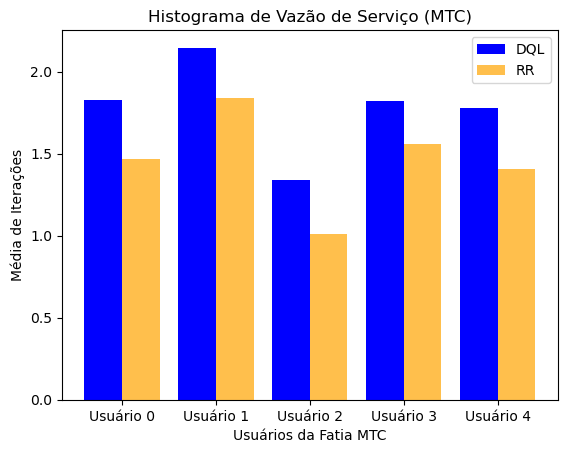

In [366]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats

# Suponha que você tenha as listas de médias e desvios padrão
means_DQN_MTC = [np.mean(lista) for lista in wait_values_DQN_MTC]
means_RR_MTC = [np.mean(lista) for lista in wait_values_RR_MTC]

# Calculo da Vazão
vazao_DQN = [user.window* user.requested_prbs / (espera + user.window) for user, espera in zip(list_MTC, means_DQN_MTC)]
vazao_RR = [user.window* user.requested_prbs / (espera + user.window) for user, espera in zip(list_MTC, means_RR_MTC)]

# Calcular o desvio padrão da vazão para DQN e RR
std_DQN_MTC = np.std(vazao_DQN, ddof=1)  # Adicionando ddof=1 para calcular o desvio padrão amostral
std_RR_MTC = np.std(vazao_RR, ddof=1)

# Criar um array de posições
posicoes = np.arange(len(means_DQN_MTC))

conf_level = 0.0
# Calcular os intervalos de confiança para DQN
ci_DQN = [stats.t.interval(conf_level, len(wait_values_DQN_MTC[i])-1, loc=means_DQN_MTC[i], scale=stats.sem(wait_values_DQN_MTC[i])) for i in range(len(means_DQN_MTC))]
lower_DQN, upper_DQN = zip(*ci_DQN)

# Calcular os intervalos de confiança para RR
ci_RR = [stats.t.interval(conf_level, len(wait_values_RR_MTC[i])-1, loc=means_RR_MTC[i], scale=stats.sem(wait_values_RR_MTC[i])) for i in range(len(means_RR_MTC))]
lower_RR, upper_RR = zip(*ci_RR)

# Criar o gráfico com barras de erro
largura = 0.4
plt.bar(posicoes - largura/2, vazao_DQN, yerr=[(u - l)/2 for l, u in zip(lower_DQN, upper_DQN)], width=largura, color='blue', label='DQL')
plt.bar(posicoes + largura/2, vazao_RR, yerr=[(u - l)/2 for l, u in zip(lower_RR, upper_RR)], width=largura, color='orange', label='RR', alpha=0.7)

# Configurar rótulos e título
plt.xlabel('Usuários da Fatia MTC')
plt.ylabel('Média de Iterações')
plt.title('Histograma de Vazão de Serviço (MTC)')

# Definir rótulos personalizados para o eixo x
plt.xticks(posicoes, [f'Usuário {i}' for i in range(len(means_DQN_MTC))])

# Adicionar legenda
plt.legend()

# Exibir o gráfico
plt.show()
